In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import struct
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 相關的模型設定

batchsize = 1024
num_epochs = 10
learning_rate = 0.001
output_class = 26

In [ ]:
# 讀取 MNIST idx 格式檔案的函數
def read_idx_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def read_idx_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# 載入訓練和測試資料
train_images = read_idx_images('D:\\Topic\\USTC-TK2016\\5_Mnist\\All\\train-images-idx3-ubyte')
train_labels = read_idx_labels('D:\\Topic\\USTC-TK2016\\5_Mnist\\All\\train-labels-idx1-ubyte')
test_images = read_idx_images('D:\\Topic\\USTC-TK2016\\5_Mnist\\All\\test-images-idx3-ubyte')
test_labels = read_idx_labels('D:\\Topic\\USTC-TK2016\\5_Mnist\\All\\test-labels-idx1-ubyte')

# 資料預處理
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# 轉換為 PyTorch tensors
train_images = torch.FloatTensor(train_images).unsqueeze(1)  # 添加通道維度
test_images = torch.FloatTensor(test_images).unsqueeze(1)
train_labels = torch.LongTensor(train_labels)
test_labels = torch.LongTensor(test_labels)

# 建立 DataLoader
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)
train_loader = DataLoader(train_dataset, batch_size = batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batchsize, shuffle=False)

In [12]:
# 定義基本 CNN 模型
class VGG(nn.Module):
    def __init__(self, num_classes = output_class):
        super(VGG, self).__init__()
        # VGG-like architecture for MNIST
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 初始化模型、損失函數和優化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# 訓練模型
train_losses = []
train_accuracies = []

print("開始訓練...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

開始訓練...
Epoch [1/10], Loss: 0.7007, Accuracy: 72.80%
Epoch [2/10], Loss: 0.0131, Accuracy: 99.55%
Epoch [3/10], Loss: 0.0095, Accuracy: 99.64%
Epoch [4/10], Loss: 0.7487, Accuracy: 70.26%
Epoch [5/10], Loss: 0.0224, Accuracy: 99.30%
Epoch [6/10], Loss: 0.0136, Accuracy: 99.52%
Epoch [7/10], Loss: 0.0109, Accuracy: 99.60%
Epoch [8/10], Loss: 0.0091, Accuracy: 99.65%
Epoch [9/10], Loss: 0.0091, Accuracy: 99.66%
Epoch [10/10], Loss: 0.0075, Accuracy: 99.71%



=== 模型評估結果 ===
測試準確率: 99.78%
測試損失: 0.0052
精確率 (Precision): 0.9978
召回率 (Recall): 0.9978
F1-Score: 0.9978


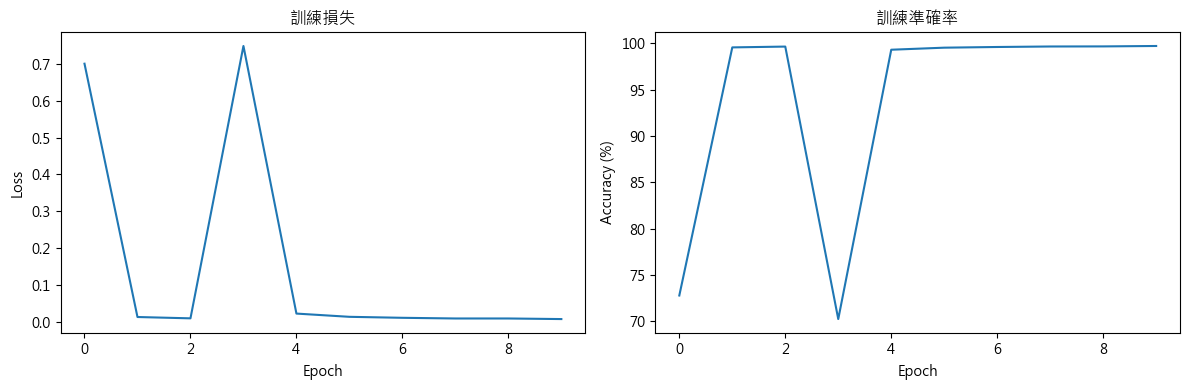

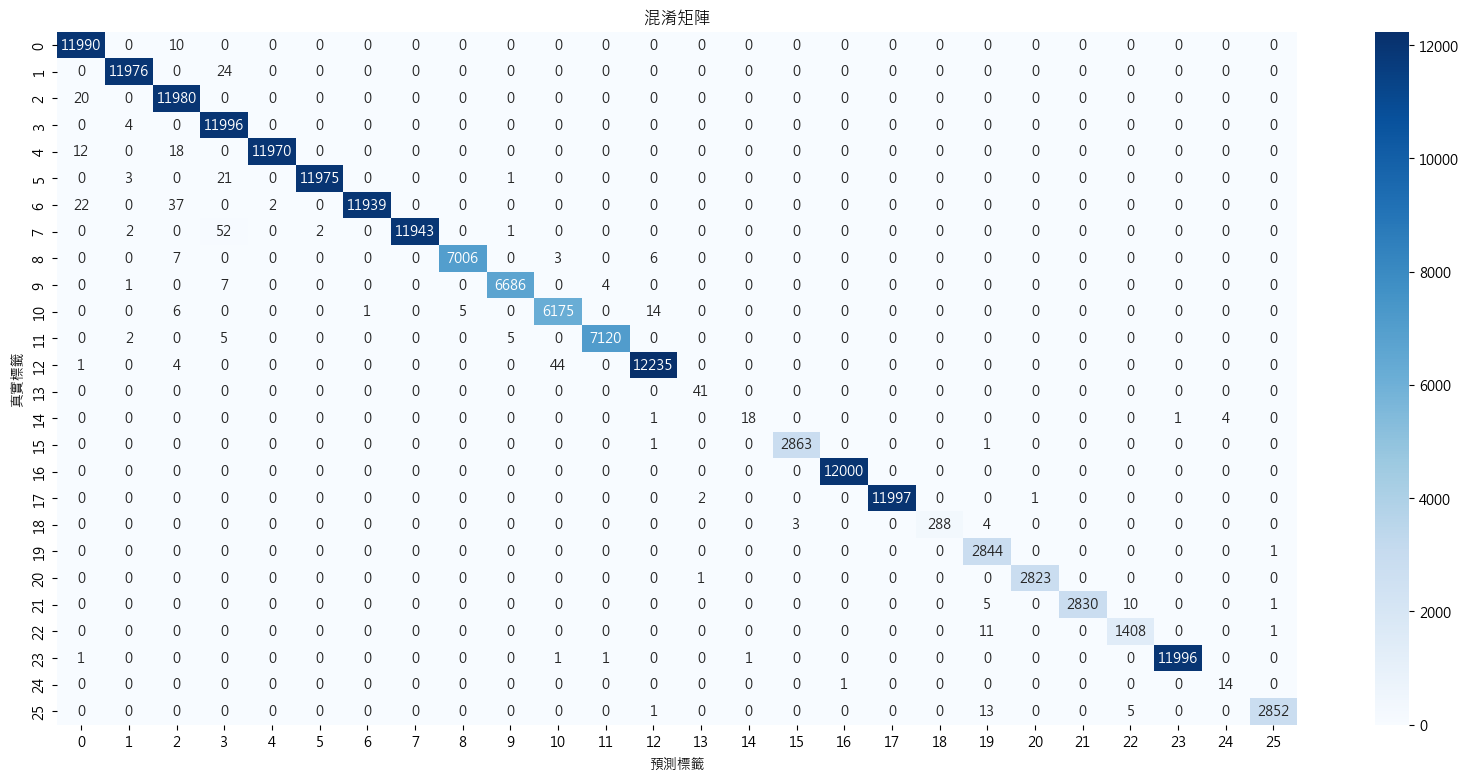

In [16]:
# 評估模型
model.eval()
y_true = []
y_pred = []
test_loss = 0
correct = 0
total = 0

plt.rc('font', family='Microsoft JhengHei')

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 計算各項指標
test_accuracy = 100 * correct / total
test_loss = test_loss / len(test_loader)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# 顯示結果
print("\n=== 模型評估結果 ===")
print(f"測試準確率: {test_accuracy:.2f}%")
print(f"測試損失: {test_loss:.4f}")
print(f"精確率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 繪製訓練過程
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses)
ax1.set_title('訓練損失')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(train_accuracies)
ax2.set_title('訓練準確率')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

# 繪製混淆矩陣
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('混淆矩陣')
plt.xlabel('預測標籤')
plt.ylabel('真實標籤')
plt.show()

In [17]:
# 儲存模型
torch.save(model.state_dict(), 'vgg_mnist_model.pth')
print("模型已儲存為 'vgg_mnist_model.pth'")

# 如果需要儲存完整模型（包含架構）
torch.save(model, 'vgg_mnist_complete_model.pth')
print("完整模型已儲存為 'vgg_mnist_complete_model.pth'")

模型已儲存為 'vgg_mnist_model.pth'
完整模型已儲存為 'vgg_mnist_complete_model.pth'
